In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy
from scipy import signal


# OS interaction
import sys, pickle, os, yaml

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as md
#from mpl_toolkits.basemap import Basemap

# turbulence package
import turbpy
import turbpy.multiConst as mc

# Location of the notebook for saving the example figure.
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

## Plot Customization

In [2]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline





# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
#%config InlineBackend.figure_format = 'retina'

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Met variables

These can be adjusted as you want.

In [3]:
goes_cues = pd.read_pickle('data/goes-cues_2017-2019.pkl')

In [4]:
cues = pd.read_pickle('data/CUES_L1_Temp_Rad_Wind_Mar-Apr2017.pkl')
# forward-fill nan values
cues = cues.fillna(method='ffill')

In [5]:
n, m = cues.index.get_loc('2017-03-20 00:00:00'), cues.index.get_loc('2017-03-21 00:00:00')
datetimes = cues.index[n:m].values
#sfcTemp = np.nanmean(cues['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'][n:m].values + 273.15)
#airTemp = cues['Platform temperature; platform temperature/relative humidity; (degrees Celsius)'][n:m].values + 273.15
#windspd = np.nanmean(cues['sonic wind speed; Sonic anemometer; (meters/second)'][n:m].values)
sfcTemp = cues['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'][n:m].values + 273.15
airTemp = cues['Platform temperature; platform temperature/relative humidity; (degrees Celsius)'][n:m].values + 273.15
windspd = cues['sonic wind speed; Sonic anemometer; (meters/second)'][n:m].values
mHeight = 6
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

Show the day we just picked

C:\Users\steve\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


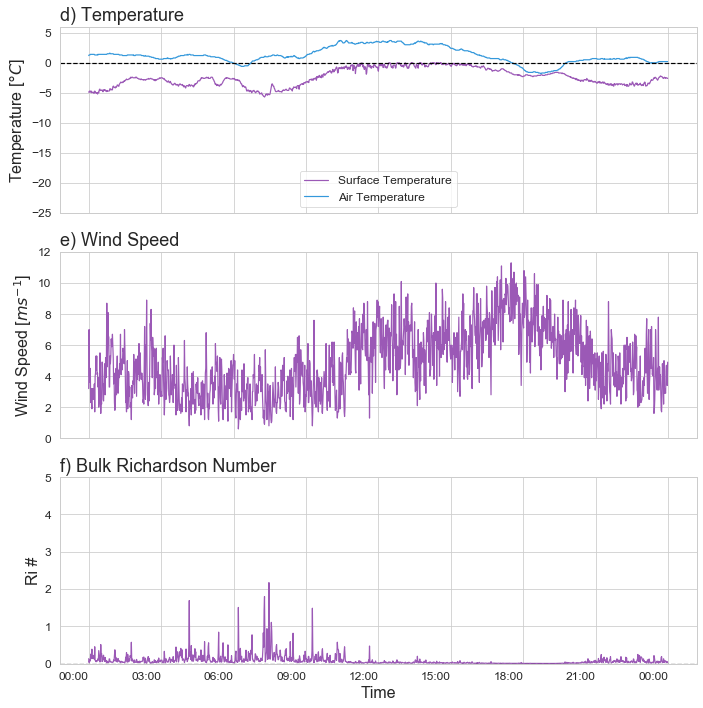

In [6]:
fig, ax = plt.subplots(3,1,figsize=(10,10))

ax[0].set_title('d) Temperature', loc='left')
ax[0].plot(datetimes, sfcTemp-273.15, label='Surface Temperature')
ax[0].plot(datetimes, airTemp-273.15, label='Air Temperature')
ax[0].set_ylabel('Temperature [$\degree C$]')
ax[0].set_ylim(-25, 6)
ax[0].axhline(0,linestyle='--',color='k')
lgd = ax[0].legend(loc='lower center', frameon=True)

ax[1].set_title('e) Wind Speed', loc='left')
ax[1].plot(datetimes, windspd)
#ax[1].axhline(0,linestyle='--',color='k')
ax[1].set_ylabel('Wind Speed [$m s^{-1}$]')
ax[1].set_ylim(0, 12)

ax[2].set_title('f) Bulk Richardson Number', loc='left')
ax[2].plot(datetimes, RiBulk)
ax[2].axhline(0,linestyle='--',color='k')
ax[2].set_ylim(0, 5)
ax[2].set_ylabel('Ri #')
ax[2].set_xlabel('Time')

xfmt = md.DateFormatter('%H:%M')
ax[2].xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate(rotation=0)
fig.tight_layout()


#ax[2].set_xlim(pd.Timestamp('2017-03-20 18'),pd.Timestamp('2017-03-20 20'))

## Adjustable parameters and parameterization method

The parameter values/options listed here are identical to the default values for turbpy. If one of the parameter values is not provided to the package, it will automatically fill in the missing values with the default values. 

In [7]:
# stab_titles are the names given to each stability scheme when plotting. In this example they correspond 
# to the dictionaries that contain the parameter values for each run. T
stab_titles = ('Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              )

# A mapping between the titles and the stability methods used in each test.
stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

# Thes gradient functions for the Monin-Obukhov methods
gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

# Parameters for the Louis scheme. Any method without a parameter value provided 
# is filled in with the default value
params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

# Indicates which methods have capping of the conductance. Any method without capping 
# indicated is assumed to have no capping.
capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}    

## Run Stability Functions

In [8]:
## Calculate stability

# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
conductance_latent = {}
sensible_heat = {}
latent_heat = {}
zeta = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros_like(RiBulk)
    conductance_sensible[stab] = np.zeros_like(RiBulk)
    conductance_latent[stab] = np.zeros_like(RiBulk)
    sensible_heat[stab] = np.zeros_like(RiBulk)
    latent_heat[stab] = np.zeros_like(RiBulk)
    zeta[stab] = np.zeros_like(RiBulk)

    
## Calculate stability
for stab in stab_titles:
    for n, (tair, vpair, tsfc, vpsfc, u) in enumerate(zip(airTemp, airVaporPress, sfcTemp, sfcVaporPress, windspd)):

        # Offline Turbulence Package
        (conductance_sensible[stab][n],
         conductance_latent[stab][n],
         sensible_heat[stab][n], 
         latent_heat[stab][n],
         stab_output, p_test) = turbpy.turbFluxes(tair, airPressure,
                                                  vpair, u, tsfc,
                                                  vpsfc, snowDepth,
                                                  mHeight, param_dict=stab_dict[stab],
                                                  z0Ground=.005)
        
        # Unpack stability parameters dictionary
        if not 'monin_obukhov' in stab_methods[stab]:
            stability_correction[stab][n] = stab_output['stabilityCorrection']
        else:
            stability_correction[stab][n] = np.nan
            zeta[stab][n] = stab_output['zeta']


C:\Users\steve\Anaconda3\lib\site-packages\turbpy-1.1-py3.6.egg\turbpy\parameter_methods.py:18: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


## Make Plots

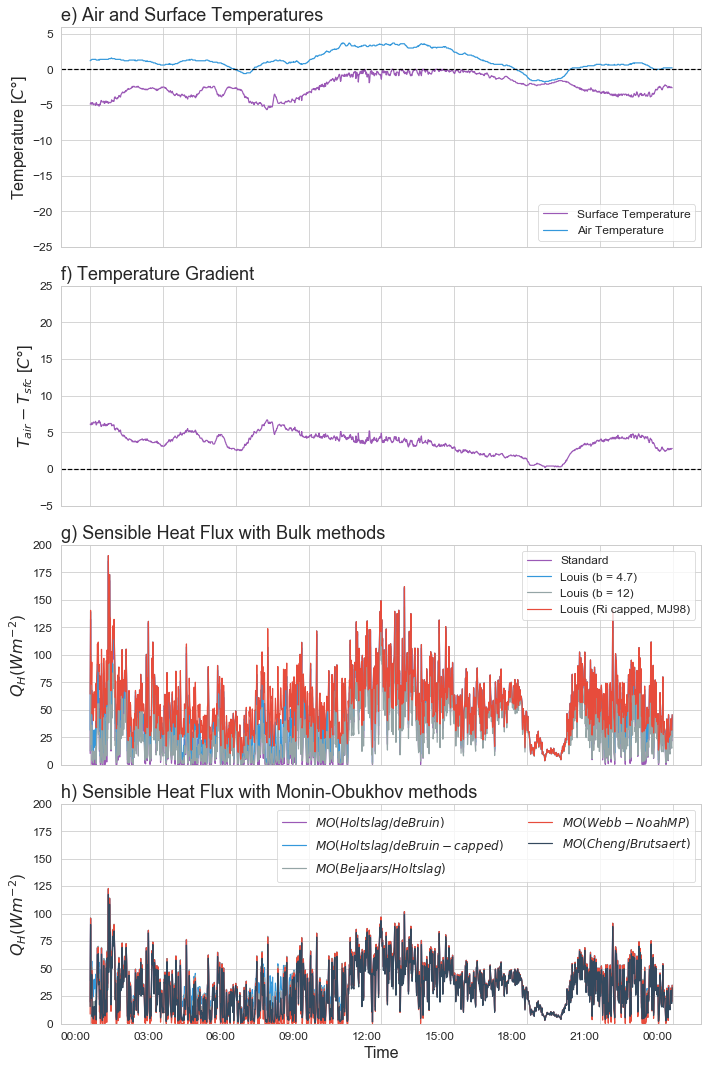

In [9]:
# Figure
fig, axes = plt.subplots(4, 1, figsize=(10, 15))
axes = axes.flatten()

# Plotting parameters
Qmax = 200
Qmin = 0
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Temperatures
ax = axes[0]
ax.plot(datetimes, sfcTemp-273.15, label='Surface Temperature')
ax.plot(datetimes, airTemp-273.15, label='Air Temperature')
ax.set_ylabel('Temperature [$C\degree$]')
ax.set_ylim(-25, 6)
ax.set_title('e) Air and Surface Temperatures', loc='left')
lgd = ax.legend(loc='lower right', frameon=True)
ax.axhline(0,linestyle='--',color='k')

# Temperature Gradient 
ax = axes[1]
ax.plot(datetimes, airTemp - sfcTemp, label='Surface Temperature')
ax.set_ylim(-5, 25)
ax.set_xlabel('Date, Time')
ax.set_ylabel('$T_{air} - T_{sfc}$ [$C\degree$]')
ax.set_title('f) Temperature Gradient', loc='left')
ax.axhline(0,linestyle='--',color='k')


# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue

    # b) Bulk Sensible Heat Flux
    ax = axes[2]
    ax.plot(datetimes, sensible_heat[stab], label=stab)#, color=colr[title]
    
    ## b) Bulk Latent Heat Flux
    #ax = axes[3]
    #ax.plot(datetimes, latent_heat[stab], label=stab)#, color=colr[title]



# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    

    # MO Sensible Heat Flux
    ax = axes[3]
    ax.plot(datetimes, sensible_heat[stab], label='$' + stab + '$')#, color=colr[title]
    
    ## MO latent Heat Flux
    #ax = axes[4]
    #ax.plot(datetimes, latent_heat[stab], label='$' + stab + '$')#, color=colr[title]
    


    
# Labels 
ax = axes[2]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlabel('Date, Time')
ax.set_ylabel('$Q_H (Wm^{-2}$)')
ax.set_title('g) Sensible Heat Flux with Bulk methods', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)
    
ax = axes[3]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlabel('Time')
ax.set_ylabel('$Q_H (Wm^{-2}$)')
ax.set_title('h) Sensible Heat Flux with Monin-Obukhov methods', loc='left')
lgd = ax.legend(loc='upper right', frameon=True, ncol=2)




xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate(rotation=0)
fig.tight_layout()



#axes[0].set_xlim(pd.Timestamp('2017-03-20 10'),pd.Timestamp('2017-03-20 14'))
#axes[1].set_xlim(pd.Timestamp('2017-03-20 18'),pd.Timestamp('2017-03-20 20'))
#axes[2].set_xlim(pd.Timestamp('2017-03-20 18'),pd.Timestamp('2017-03-20 20'))

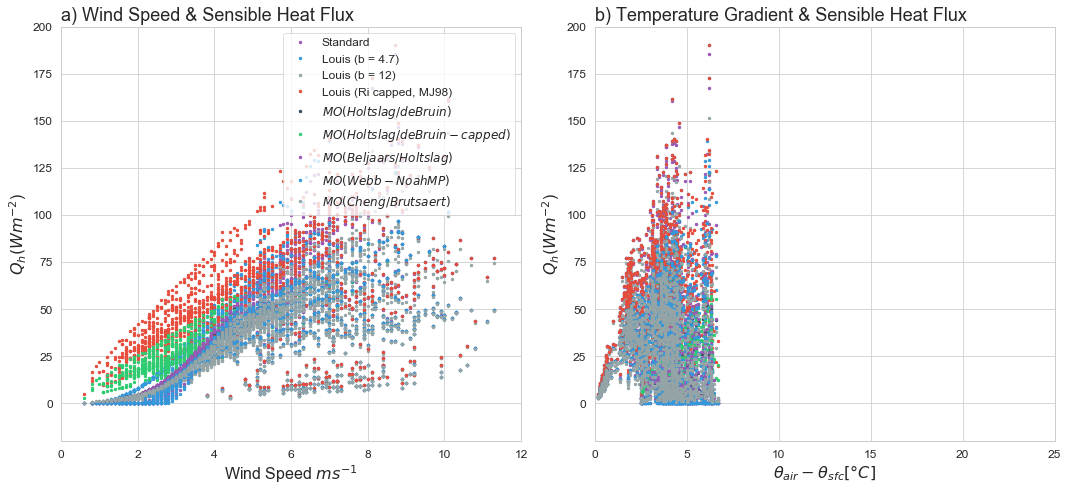

In [10]:
# Figure
fig, axes = plt.subplots(1,2, figsize=(15, 7))


# Plotting parameters
Qmax = 200
Qmin = -20
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)


# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    # b) Bulk Sensible Heat Flux
    ax = axes[0]
    ax.plot(windspd, sensible_heat[stab], '.', label=stab)#, color=colr[title]

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    # d) MO Sensible Heat Flux
    ax = axes[0]
    ax.plot(windspd, sensible_heat[stab], '.', label='$' + stab + '$')#, color=colr[title]

ax = axes[0]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(0, 12)
ax.set_xlabel('Wind Speed $m s^{-1}$')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('a) Wind Speed & Sensible Heat Flux', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)


# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue

    # b) Bulk Sensible Heat Flux
    ax = axes[1]
    ax.plot((airTemp-273.15)-(sfcTemp-273.15), sensible_heat[stab], '.', label=stab)#, color=colr[title]

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    

    # d) MO Sensible Heat Flux
    ax = axes[1]
    ax.plot((airTemp-273.15)-(sfcTemp-273.15), sensible_heat[stab], '.', label='$' + stab + '$')#, color=colr[title]
    

ax = axes[1]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlabel('$ \\theta _{air} - \\theta _{sfc}[\degree C]$')
ax.set_xlim(0, 25)
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Temperature Gradient & Sensible Heat Flux', loc='left')
#lgd = ax.legend(loc='upper left', frameon=True, ncol=2, fontsize=10)



fig.tight_layout()


---
---

### Compute an ensemble mean sensible and latent heat flux, throwing out the "capped" methods

In [33]:
sensibleHeat_mean = np.zeros_like(sensible_heat['Standard'])
latentHeat_mean = np.zeros_like(latent_heat['Standard'])

for stab in stab_titles:
    if not (stab == 'Louis (Ri capped, MJ98)') or (stab == 'MO (Holtslag/de Bruin - capped)'):
        sensibleHeat_mean = sensibleHeat_mean + sensible_heat[stab]
        latentHeat_mean = latentHeat_mean + latent_heat[stab]
        
sensibleHeat_mean = sensibleHeat_mean/7 # divide by 7 because we have 7 methods
latentHeat_mean = latentHeat_mean/7 # divide by 7 because we have 7 methods

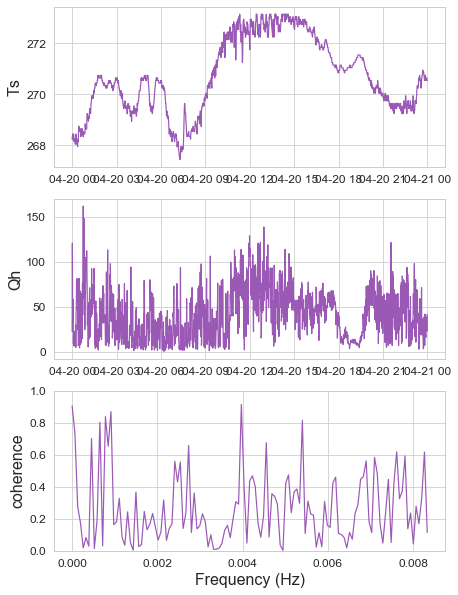

In [62]:
"""
Compute the coherence of two signals
Coherence is the normalized cross spectral density
--------------------------------------------------------
https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.cohere.html
https://matplotlib.org/examples/pylab_examples/cohere_demo.html
https://stackoverflow.com/questions/21647120/how-to-use-the-cross-spectral-density-to-calculate-the-phase-shift-of-two-relate
"""
# indicies if I want to look at a shorter time span
n, m = [0,len(datetimes)-0]

nfft = 256
dt = 60
t = np.arange(0, len(datetimes[n:m]), dt)
r = np.exp(-t/0.05)

# our two signals
s1 = sfcTemp[n:m] # snow surface temperature, Ts
s2 = sensibleHeat_mean[n:m] # Sensible heat flux, Qh

plt.figure(figsize=(7,10))
plt.subplot(311)
plt.plot(datetimes[n:m], s1)
#plt.xlim(0,5)
#plt.xlabel('time')
plt.ylabel('Ts')
plt.grid(True)
ax = plt.gca()

plt.subplot(312)
plt.plot(datetimes[n:m], s2)
#plt.xlim(0,5)
#plt.xlabel('time')
plt.ylabel('Qh')
plt.grid(True)

plt.subplot(313)
cxy, f = plt.cohere(s1, s2, nfft, 1./dt)
plt.ylim((0,1))
plt.ylabel('coherence')
plt.xlabel('Frequency (Hz)')
plt.show()



#.tight_layout()

########################
## use scipy
#, Cxy = signal.coherence(s1, s2, 1./dt)
#lt.figure(figsize=(10,4))
#lt.plot(f, Cxy)
#lt.xlabel('frequency [Hz]')
#lt.ylabel('Coherence')
#lt.ylim((0,1))
#lt.show()

Text(0.5, 0, 'Frequency (Hz)')

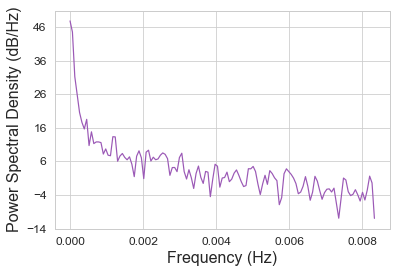

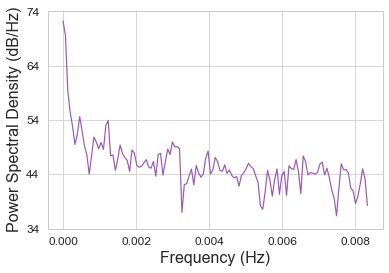

In [50]:
nfft = 256
dt = 60 # one sample per 60 seconds

# PSDs
plt.figure()
plt.psd(sfcTemp-273.15, nfft, 1/dt, label='U\'')
plt.xlabel('Frequency (Hz)')
#plt.xscale('log')
#plt.ylim(0,40)


# PSDs
plt.figure()
plt.psd(sensibleHeat_mean, nfft, 1/dt, label='U\'')
plt.xlabel('Frequency (Hz)')
#plt.xscale('log')
#plt.ylim(0,40)


In [12]:
#nfft = 256
#dt = 60
#
## our two signals
#s1 = sfcTemp[n:m] # snow surface temperature, Ts
#s2 = sensible_heat['MO (Holtslag/de Bruin - capped)'][n:m] # Sensible heat flux, Qh
#
#plt.figure(figsize=(10,5))
#
#plt.subplot(121)
#plt.psd(s1, nfft, 1/dt)
#plt.title('Ts')
#plt.xscale('log')
#plt.yscale('log')
#
#plt.subplot(122)
#plt.psd(s2, nfft, 1/dt)
#plt.title('Qh')
#plt.xscale('log')
#plt.yscale('log')
#
#plt.tight_layout()
#plt.show()

---
## Looking at sonic anemometer data

In [13]:
def reynolds_decomposition(scalar, window=30):
    
    s_bar = scalar.rolling(window).mean()
    s_prime = scalar - s_bar
    
    return s_bar, s_prime

In [14]:
n, m = cues.index.get_loc('2017-04-20 00:00:00'), cues.index.get_loc('2017-04-21 00:00:00')

datetimes = cues.index[n:m].values

u_bar, u_prime = reynolds_decomposition(cues.Sonic3D_U[n:m])
u_bar = u_bar[~u_bar.isnull()]
u_prime = u_prime[~u_prime.isnull()]

v_bar, v_prime = reynolds_decomposition(cues.Sonic3D_V[n:m])
v_bar = v_bar[~v_bar.isnull()]
v_prime = v_prime[~v_prime.isnull()]

w_bar, w_prime = reynolds_decomposition(cues.Sonic3D_W[n:m])
w_bar = w_bar[~w_bar.isnull()]
w_prime = w_prime[~w_prime.isnull()]

ta_bar, ta_prime = reynolds_decomposition(cues.Temp[n:m])
ta_bar = ta_bar[~ta_bar.isnull()]
ta_prime = ta_prime[~ta_prime.isnull()]

ts_bar, ts_prime = reynolds_decomposition(cues['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'][n:m])
ts_bar = ts_bar[~ts_bar.isnull()]
ts_prime = ts_prime[~ts_prime.isnull()]

nfft = 256
dt = 60 # one sample per 60 seconds

### Time averaged u, v, w, T, Ts plots

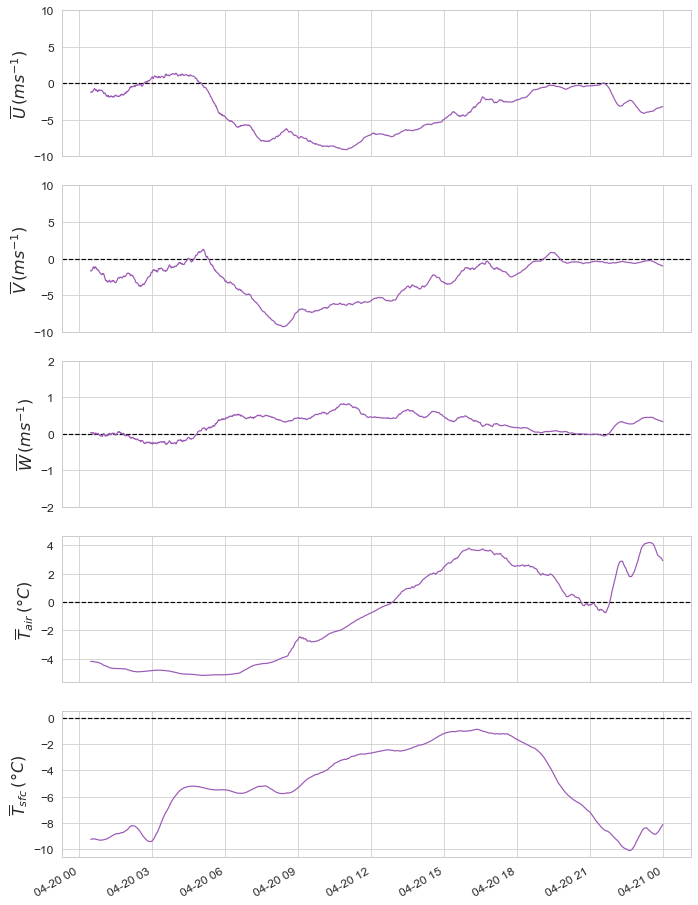

In [15]:
fig = plt.figure(figsize=(10,15))

plt.subplot(511)
plt.plot(u_bar)
plt.ylabel('$\overline{U}\,(ms^{-1})$')
plt.axhline(0, linestyle='--', color='k',zorder=1)
plt.ylim(-10,10)

plt.subplot(512)
plt.plot(v_bar)
plt.ylabel('$\overline{V}\,(ms^{-1})$')
plt.axhline(0, linestyle='--', color='k',zorder=1)
plt.ylim(-10,10)

plt.subplot(513)
plt.plot(w_bar)
plt.ylabel('$\overline{W}\,(ms^{-1})$')
plt.axhline(0, linestyle='--', color='k',zorder=1)
plt.ylim(-2,2)

plt.subplot(514)
plt.plot(ta_bar)
plt.ylabel('$\overline{T}_{air}\,(\degree C)$')
plt.axhline(0, linestyle='--', color='k',zorder=1)

plt.subplot(515)
plt.plot(ts_bar)
plt.ylabel('$\overline{T}_{sfc}\,(\degree C)$')
plt.axhline(0, linestyle='--', color='k',zorder=1)

plt.tight_layout()
fig.autofmt_xdate()

### u', v', w', T', Ts' plots

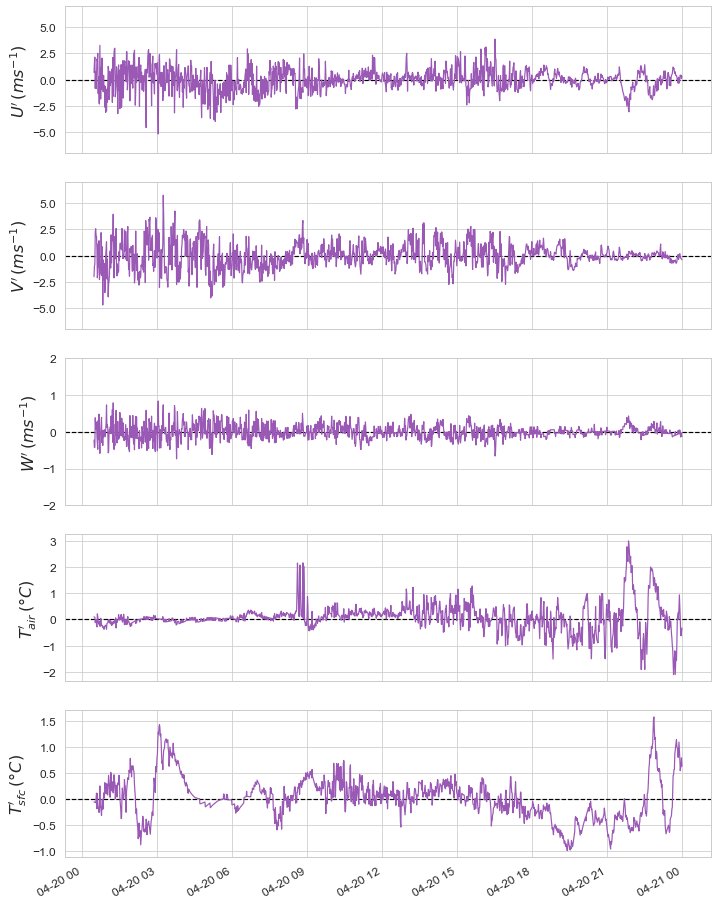

In [16]:
fig = plt.figure(figsize=(10,15))

plt.subplot(511)
plt.plot(u_prime)
plt.ylabel('$U\'\,(ms^{-1})$')
plt.axhline(0, linestyle='--', color='k',zorder=1)
plt.ylim(-7,7)

plt.subplot(512)
plt.plot(v_prime)
plt.ylabel('$V\'\,(ms^{-1})$')
plt.axhline(0, linestyle='--', color='k',zorder=1)
plt.ylim(-7,7)

plt.subplot(513)
plt.plot(w_prime)
plt.ylabel('$W\'\,(ms^{-1})$')
plt.axhline(0, linestyle='--', color='k',zorder=1)
plt.ylim(-2,2)

plt.subplot(514)
plt.plot(ta_prime)
plt.ylabel('$T_{air}\'\,(\degree C)$')
plt.axhline(0, linestyle='--', color='k',zorder=1)

plt.subplot(515)
plt.plot(ts_prime)
plt.ylabel('$T_{sfc}\'\,(\degree C)$')
plt.axhline(0, linestyle='--', color='k',zorder=1)

plt.tight_layout()
fig.autofmt_xdate()

### Histograms and PSD Plots

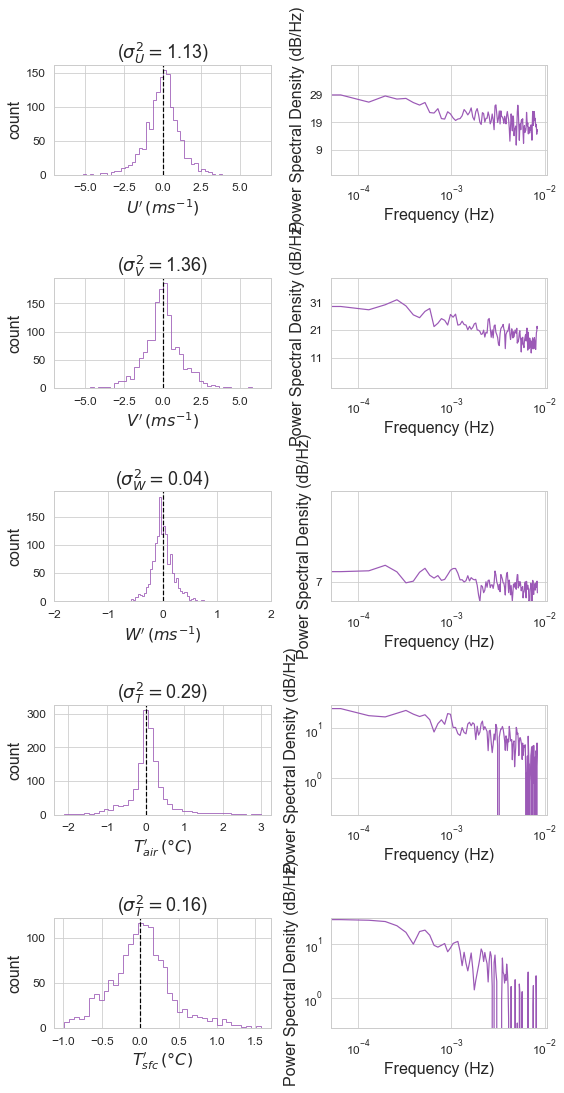

In [17]:

fig = plt.figure(figsize=(8,15))

# Histograms
plt.subplot(521)
plt.hist(u_prime, bins=40, histtype='step')
plt.xlabel('$U\'\,(ms^{-1})$')
plt.axvline(0, linestyle='--', color='k',zorder=1)
plt.xlim(-7,7)
plt.ylabel('count')
plt.title('($\sigma^2_U = ${})'.format(np.round(np.std(u_prime)**2,2)))

plt.subplot(523)
plt.hist(v_prime, bins=40, histtype='step')
plt.xlabel('$V\'\,(ms^{-1})$')
plt.axvline(0, linestyle='--', color='k',zorder=1)
plt.xlim(-7,7)
plt.ylabel('count')
plt.title('($\sigma^2_V = ${})'.format(np.round(np.std(v_prime)**2,2)))

plt.subplot(525)
plt.hist(w_prime, bins=40, histtype='step')
plt.xlabel('$W\'\,(ms^{-1})$')
plt.axvline(0, linestyle='--', color='k',zorder=1)
plt.xlim(-2,2)
plt.ylabel('count')
plt.title('($\sigma^2_W = ${})'.format(np.round(np.std(w_prime)**2,2)))

plt.subplot(527)
plt.hist(ta_prime, bins=40, histtype='step')
plt.xlabel('$T_{air}\'\,(\degree C)$')
plt.axvline(0, linestyle='--', color='k',zorder=1)
plt.ylabel('count')
plt.title('($\sigma^2_T = ${})'.format(np.round(np.std(ta_prime)**2,2)))

plt.subplot(529)
plt.hist(ts_prime, bins=40, histtype='step')
plt.xlabel('$T_{sfc}\'\,(\degree C)$')
plt.axvline(0, linestyle='--', color='k',zorder=1)
plt.ylabel('count')
plt.title('($\sigma^2_T = ${})'.format(np.round(np.std(ts_prime)**2,2)))

# PSDs
plt.subplot(522)
plt.psd(u_prime, nfft, 1/dt, label='U\'')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.ylim(0,40)


plt.subplot(524)
plt.psd(v_prime, nfft, 1/dt, label='V\'')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.ylim(0,40)


plt.subplot(526)
plt.psd(w_prime, nfft, 1/dt, label='W\'')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.ylim(0,40)


plt.subplot(528)
plt.psd(ta_prime, nfft, 1/dt, label='T_{air}\'')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(-30,30)

plt.subplot(5,2,10)
plt.psd(ts_prime, nfft, 1/dt, label='T_{sfc}\'')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(-30,30)



plt.tight_layout()

---

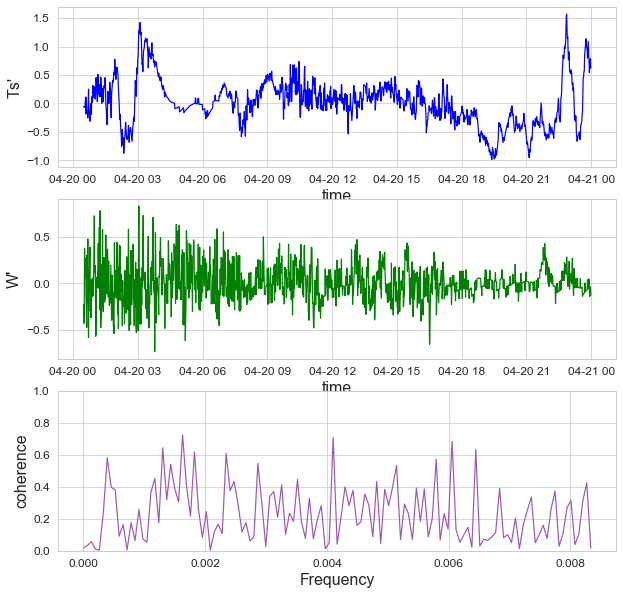

In [18]:
"""
Compute the coherence of two signals
Coherence is the normalized cross spectral density
--------------------------------------------------------
https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.cohere.html
https://matplotlib.org/examples/pylab_examples/cohere_demo.html
https://stackoverflow.com/questions/21647120/how-to-use-the-cross-spectral-density-to-calculate-the-phase-shift-of-two-relate
"""


nfft = 256
dt = 60
#t = np.arange(0, len(datetimes[n:m]), dt)
#r = np.exp(-t/0.05)

# our two signals
s1 = ts_prime
s2 = w_prime # Sensible heat flux, Qh

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(s1, 'b-')
#plt.xlim(0,5)
plt.xlabel('time')
plt.ylabel('Ts\'')
plt.grid(True)

plt.subplot(312)
plt.plot(s2, 'g-')
#plt.xlim(0,5)
plt.xlabel('time')
plt.ylabel('W\'')
plt.grid(True)

plt.subplot(313)
cxy, f = plt.cohere(s1, s2, nfft, 1./dt)
plt.ylim((0,1))
plt.ylabel('coherence')
plt.show()


########################
## use scipy
#f, Cxy = signal.coherence(s1, s2, 1./dt)
#plt.figure(figsize=(10,4))
#plt.plot(f, Cxy)
#plt.xlabel('frequency [Hz]')
#plt.ylabel('Coherence')
#plt.ylim((0,1))
#plt.show()

In [19]:
s1

datetime
2017-04-20 00:29:00   -0.053333
2017-04-20 00:30:00   -0.060000
2017-04-20 00:31:00   -0.063333
2017-04-20 00:32:00   -0.066667
2017-04-20 00:33:00   -0.070000
                         ...   
2017-04-20 23:55:00    0.543333
2017-04-20 23:56:00    0.596667
2017-04-20 23:57:00    0.646667
2017-04-20 23:58:00    0.786667
2017-04-20 23:59:00    0.626667
Name: snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius), Length: 1411, dtype: float64

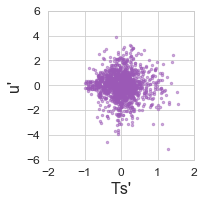

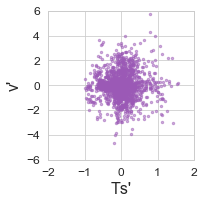

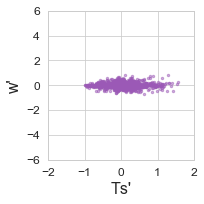

In [20]:
plt.figure(figsize=(3,3))
plt.plot(ts_prime,u_prime,'.',alpha=0.5)
plt.xlabel('Ts\'')
plt.ylabel('u\'')
plt.xlim(-2,2)
plt.ylim(-6,6)
plt.tight_layout()

plt.figure(figsize=(3,3))
plt.plot(ts_prime,v_prime,'.',alpha=0.5)
plt.xlabel('Ts\'')
plt.ylabel('v\'')
plt.xlim(-2,2)
plt.ylim(-6,6)
plt.tight_layout()

plt.figure(figsize=(3,3))
plt.plot(ts_prime,w_prime,'.',alpha=0.5)
plt.xlabel('Ts\'')
plt.ylabel('w\'')
plt.xlim(-2,2)
plt.ylim(-6,6)
plt.tight_layout()